In [1]:
using Rasters
using RasterDataSources
using ArchGDAL
using GLMakie
using Makie.GeometryBasics
using Makie.GeometryBasics: Tesselation, uv_normal_mesh
using DataInterpolations, Printf

function watermap(uv, water, normalization=908.0f0 * 4.0f0)
  markersize = map(uv) do uv
    wsize = reverse(size(water))
    wh = wsize .- 1
    x, y = round.(Int, Tuple(uv) .* wh) .+ 1
    val = water[size(water)[1]-(y-1), x] / normalization
    (isnan(val) || (val < 0.0)) ? -1.0f0 : val
  end
end

raster2array(raster) = Makie.convert_arguments(Makie.ContinuousSurface(), raster)[3]


raster2array (generic function with 1 method)

In [2]:
ENV["RASTERDATASOURCES_PATH"] = "data"
worldclim_stacks = [RasterStack(WorldClim{Climate}, month=i) for i in 1:12]

temp_rasters = getproperty.(worldclim_stacks, :tmax)
prec_rasters = getproperty.(worldclim_stacks, :prec)

temp_interpolated = DataInterpolations.QuadraticInterpolation(temp_rasters, 1:length(temp_rasters), extrapolate=true)
prec_interpolated = DataInterpolations.QuadraticInterpolation(prec_rasters, 1:length(temp_rasters), extrapolate=true)


24-element QuadraticInterpolation{Vector{Raster{Int16, 2, Tuple{X{Projected{Float64, LinRange{Float64, Int64}, DimensionalData.Dimensions.LookupArrays.ForwardOrdered, DimensionalData.Dimensions.LookupArrays.Regular{Float64}, DimensionalData.Dimensions.LookupArrays.Intervals{DimensionalData.Dimensions.LookupArrays.Start}, DimensionalData.Dimensions.LookupArrays.Metadata{Rasters.GDALsource, Dict{String, Any}}, WellKnownText{GeoFormatTypes.CRS}, Nothing, X{Colon}}}, Y{Projected{Float64, LinRange{Float64, Int64}, DimensionalData.Dimensions.LookupArrays.ReverseOrdered, DimensionalData.Dimensions.LookupArrays.Regular{Float64}, DimensionalData.Dimensions.LookupArrays.Intervals{DimensionalData.Dimensions.LookupArrays.Start}, DimensionalData.Dimensions.LookupArrays.Metadata{Rasters.GDALsource, Dict{String, Any}}, WellKnownText{GeoFormatTypes.CRS}, Nothing, Y{Colon}}}}, Tuple{}, Matrix{Int16}, Symbol, DimensionalData.Dimensions.LookupArrays.Metadata{Rasters.GDALsource, Dict{String, Any}}, Int16}

In [3]:
m = Makie.GeometryBasics.uv_normal_mesh(
  Makie.GeometryBasics.Tesselation(
    Makie.GeometryBasics.Sphere(
      Point3f(0), 1.0f0
    ),
    200
  )
);

p = decompose(Point3f0, m)
uv = decompose_uv(m)
norms = decompose_normals(m);


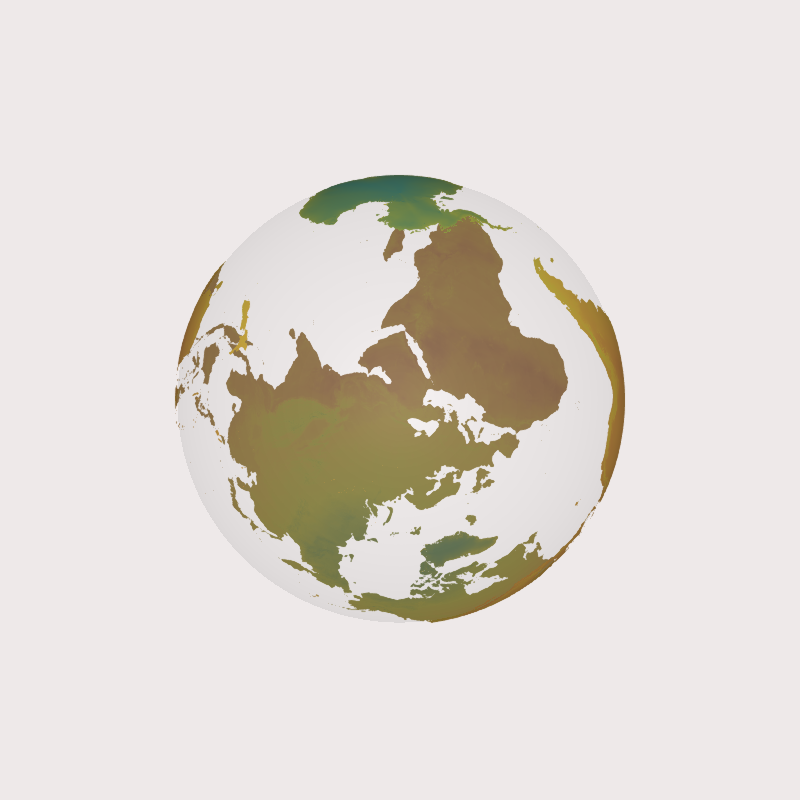

In [4]:
cmap = [:darkblue, :deepskyblue2, :deepskyblue, :gold, :tomato3, :red, :darkred]
# this colormap is fun, but its confusing when including also the one for precipitation.
Makie.to_colormap(cmap) # hide

fig = Figure(resolution=(800, 800), backgroundcolor=:snow2)
# First, we plot an empty the sphere
ax, plt_obj = mesh(fig[1, 1], uv_normal_mesh(Tesselation(Sphere(Point3f(0), 0.99), 128));
  color=(:white, 0.1), transparency=true,
  axis=(type=LScene, show_axis=false)
)

# Then, we plot the sphere, which displays temperature.
temperature_plot = mesh!(
  m;
  color=Makie.convert_arguments(Makie.ContinuousSurface(), worldclim_stacks[10].tmax)[3]',
  colorrange=(-50, 50),
  colormap=:tableau_temperature, #cmap,
  shading=true,
  transparency=false
)
fig


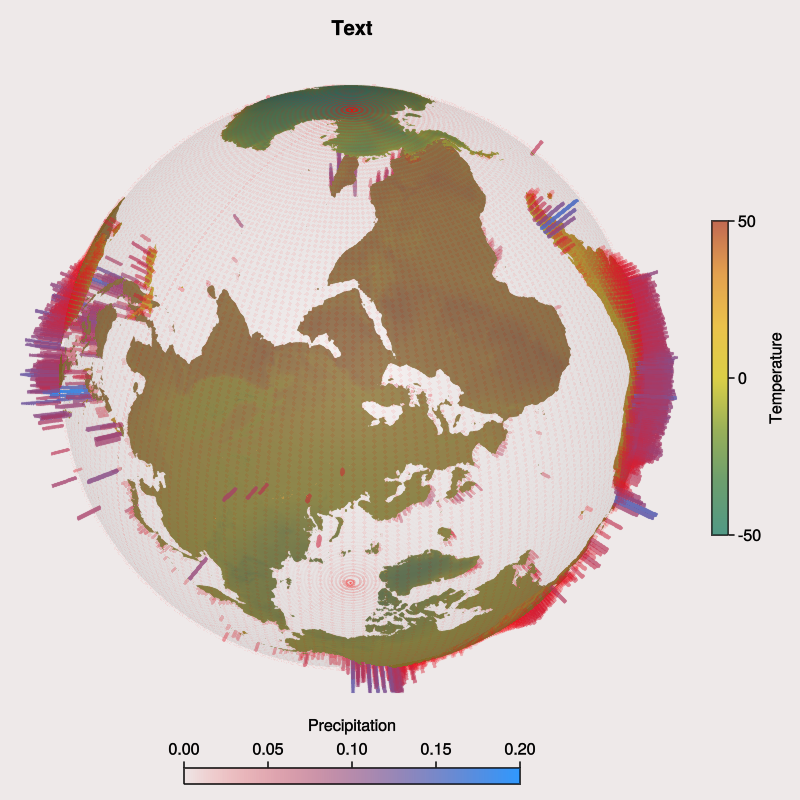

In [6]:
watervals = watermap(uv, raster2array(worldclim_stacks[1].prec)')

xy_width = 0.01
prec_plot = meshscatter!(
  p, # the positions of the tessellated mesh we got last time
  rotations=norms, # rotate according to the normal vector, pointing out of the sphere
  marker=Rect3(Vec3f(0), Vec3f(1)), # unit box
  markersize=Vec3f0.(xy_width, xy_width, max.(0, watervals)), # scale by 0.01 in x and y, and `watervals` in z
  color=max.(0, watervals),
  colorrange=(0, 0.2),
  colormap=[(:red, 0.01), (:dodgerblue, 0.7)],
  shading=false,
  transparency=true,
)

title_label = Label(fig[0, 1]; tellwidth=false, font=:bold, fontsize=20)
Colorbar(fig[1, 2], temperature_plot, label="Temperature", height=Relative(0.5))
Colorbar(fig[2, 1], prec_plot, label="Precipitation", width=Relative(0.5), vertical=false)

zoom!(ax.scene, cameracontrols(ax.scene), 0.65)
fig


In [7]:
record(fig, "worldclim_visualization.mp4", LinRange(1, 24, 600 ÷ 4); framerate=24) do i
  title_label.text[] = @sprintf "%.2f" (i % 12)
  mat_temp = raster2array(temp_interpolated(i % 12))
  mat_temp[mat_temp .< -50] .= NaN
  mat_temp[mat_temp .> 50] .= NaN

  temperature_plot.color[] = mat_temp'
  watervals = max.(0, watermap(uv, raster2array(prec_interpolated(i % 12))'))
  prec_plot.color[] = watervals
  prec_plot.markersize[] .= Vec3f0.(xy_width, xy_width, watervals)
  # since we modify markersize inplace above, we need to notify the signal
  rotate!(ax.scene, i / 8)
  notify(prec_plot.markersize)
end


ArgumentError: ArgumentError: indexed assignment with a single value to possibly many locations is not supported; perhaps use broadcasting `.=` instead?